# Mise en situation

Dans ce projet, nous avons intégré une société de consulting et cette dernière nous propose une nouvelle mission au ministère de l'Intérieur dans le cadre de la lutte contre le faux monnayage.

Nous allons donc crée un algorithme de détection de faux billets.

Un jeu de données contenant les caractéristiques géométriques de billets de banque. Pour chacun d'eux, nous connaissons :

la longueur du billet (en mm) ;

la hauteur du billet (mesurée sur le côté gauche, en mm) ;

la hauteur du billet (mesurée sur le côté droit, en mm) ;

la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;

la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;

la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;

la diagonale du billet (en mm).

In [419]:
#pip install statsmodels

In [420]:
# import de librairies nécessaires

import pandas as pd
import numpy as np
from math import *
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.spatial.distance import cdist
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import decomposition
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


from matplotlib.collections import LineCollection
import matplotlib.mlab as mlab
import scipy as st
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy import stats, optimize, interpolate
from scipy.stats import norm


import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn import decomposition
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline
from IPython.core.display import HTML 
import warnings 
warnings.filterwarnings('ignore')
HTML("""<style> .output_png {display: table-cell; text-align: center; vertical-align: middle} </style>""")

#Import de fonctions utiles
from functions import *

# 



# Description du jeu de données

La PJ a transmis un fichier csv contenant les caractéristiques enoncées ci-dessus. Une première analyse est nécessaire pour pouvoir se faire une idée plus précise des données que nous avons à disposition.

A l'exception de la variable booléenne 'is_genuine', les 6 autres variables sont quantitatives continues.

In [421]:
# verification des nombres des lignes et des colonnes

df.shape

(170, 8)

Le jeu de données contient 170 observations et  7 variables.

Nous allons afficher la distribution de chaque variable pour vérifier graphiquement :

In [422]:
# importation csv file
data = pd.read_csv("billet.csv")
df=pd.DataFrame(data)
df.head()


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [423]:
#Représentation des effectifs par type de billet vrai/faux(méthode utilisée .value_counts())
effectif = df['is_genuine'].value_counts()
modalite = effectif.index #l'index de 'effectifs' contient les modalités

tab = pd.DataFrame(modalite, columns = ['is_genuine']) #création du tableau à partir des modalités
tab["n"] = effectif.values
tab["f"] = tab["n"] / len(data) #len(data) renvoie la taille de l'échantillon
tab

,is_genuine,n,f
0,True,100,0.588235
1,False,70,0.411765


On observe qu'il y a 100 Vrais billets et 70 Faux billets.

In [424]:
# Description
df.describe(include="all")

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,170,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,NaN,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,NaN,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,NaN,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,NaN,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,NaN,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500


On remarque ici qu'il ne semble pas y avoir de valeurs aberrantes, is_genuine ne compte bien que 2 valeurs par exemple. Les moyennes, minimum et maximum semblent cohérent ainsi que les écart-types.

In [425]:
#Valeurs descriptives des variables quantitatives
data.describe().T

,count,mean,std,min,25%,50%,75%,max
diagonal,170.0,171.940588,0.305768,171.04,171.7300,171.945,172.1375,173.01
height_left,170.0,104.066353,0.298185,103.23,103.8425,104.055,104.2875,104.86
height_right,170.0,103.928118,0.330980,103.14,103.6900,103.950,104.1700,104.95
margin_low,170.0,4.612118,0.702103,3.54,4.0500,4.450,5.1275,6.28
margin_up,170.0,3.170412,0.236361,2.27,3.0125,3.170,3.3300,3.68
length,170.0,112.570412,0.924448,109.97,111.8550,112.845,113.2875,113.98


Ce tableau permet d'avoir une première idée des données que nous avons. Synthétique et très rapide à établir, c'est un point d'entré pertinent avant de pouvoir mieux connaître les variables et individus de l'échantillon.

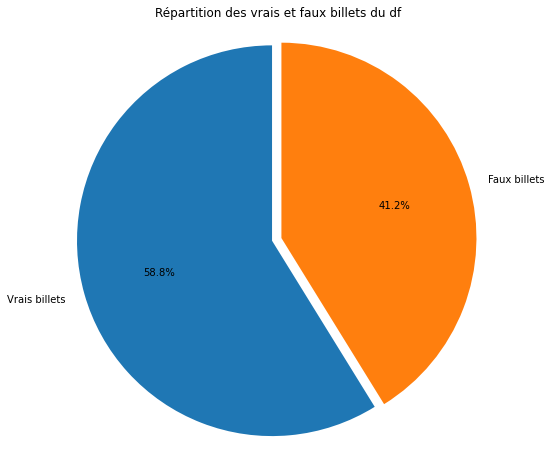

In [426]:
#Création d'un Pie Chart pour représenter la part de chaque type de billet
labels = 'Vrais billets', 'Faux billets'
sizes = tab['f']
explode = (0.05, 0)

fig1, ax = plt.subplots(figsize=(8,8))
ax.pie(sizes, explode=explode, labels=labels, 
        autopct='%1.1f%%', shadow=False, startangle=90)

ax.axis('equal') 
plt.title('Répartition des vrais et faux billets du df')
plt.savefig('P6_02_graphiques/Répartition des vrais et faux billets.jpeg', format='jpg', bbox_inches='tight')
plt.show()

Nous avons 58.8 % vrais billets

Nous avons 41.2% faux billets



# Analysons les variables indépendamment pour vérifier leur distribution globale.

In [427]:
#Création de variables
length = df['length']
height_left = df['height_left']
height_right = df['height_right']
margin_low = df['margin_low']
margin_up = df['margin_up']
diagonal = df['diagonal']


In [428]:
df['is_genuine'].unique()

array([ True, False])

In [429]:
vrais_billets = df[df['is_genuine'] == True]
faux_billets = df[df['is_genuine'] == False]

In [430]:
vrais_billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
95,True,172.49,103.92,103.91,4.42,2.84,113.38
96,True,172.00,104.32,104.26,4.53,3.04,112.93
97,True,171.49,103.77,103.60,4.01,3.09,112.95
98,True,172.10,103.98,103.86,4.47,3.06,113.00


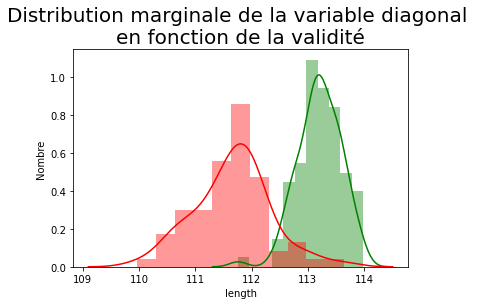

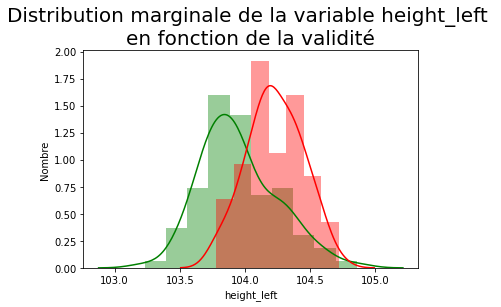

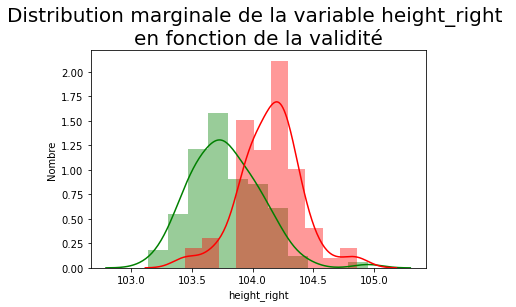

In [431]:
#Distribution marginale de la varialbe length en fonction de la validité
sns.distplot(vrais_billets['length'], color='green', kde=True)
sns.distplot(faux_billets['length'], color='red', kde=True)
plt.ylabel('Nombre')
plt.title(f'Distribution marginale de la variable {df.columns[1]} \nen fonction de la validité',
          fontsize=20)
plt.savefig('P6_02_graphiques/Distribution marginale de la variable de la varable diagonal.jpeg', format='jpg', bbox_inches='tight')

plt.show()

#Distribution marginale de la varialbe height_left en fonction de la validité
sns.distplot(vrais_billets['height_left'], color='green', kde=True)
sns.distplot(faux_billets['height_left'], color='red', kde=True)
plt.ylabel('Nombre')
plt.title(f'Distribution marginale de la variable {df.columns[2]} \nen fonction de la validité',
          fontsize=20)
plt.savefig('P6_02_graphiques/Distribution marginale de la variable de la varable height_left.jpeg', format='jpg', bbox_inches='tight')


plt.show()

#Distribution marginale de la varialbe height_right en fonction de la validité
sns.distplot(vrais_billets['height_right'], color='green', kde=True)
sns.distplot(faux_billets['height_right'], color='red', kde=True)
plt.ylabel('Nombre')
plt.title(f'Distribution marginale de la variable {df.columns[3]} \nen fonction de la validité',
          fontsize=20)
plt.savefig('P6_02_graphiques/Distribution marginale de la variable de la varable height_right.jpeg', format='jpg', bbox_inches='tight')


plt.show()

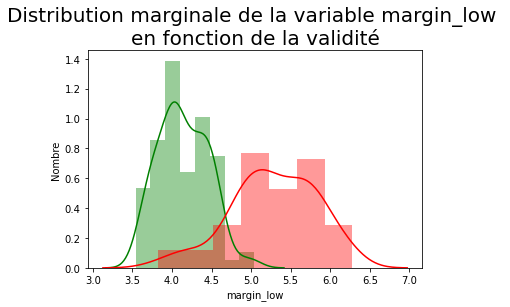

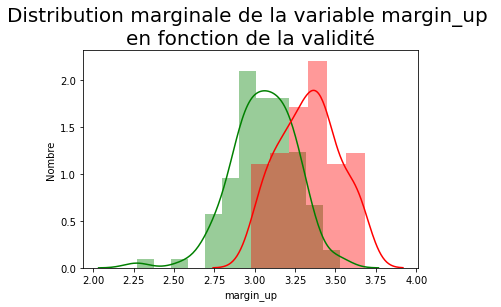

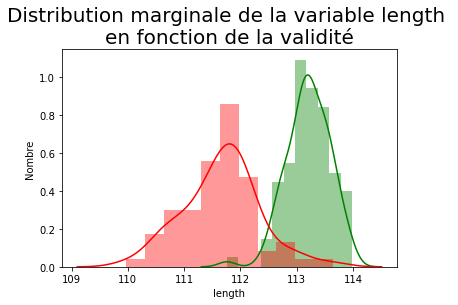

In [432]:
#Distribution marginale de la varialbe margin_low en fonction de la validité
sns.distplot(vrais_billets['margin_low'], color='green', kde=True)
sns.distplot(faux_billets['margin_low'], color='red', kde=True)
plt.ylabel('Nombre')
plt.title(f'Distribution marginale de la variable {df.columns[4]} \nen fonction de la validité',
          fontsize=20)
plt.savefig('P6_02_graphiques/Distribution marginale de la variable de la varable margin_low.jpeg', format='jpg', bbox_inches='tight')


plt.show()

#Distribution marginale de la varialbe margin_up en fonction de la validité
sns.distplot(vrais_billets['margin_up'], color='green', kde=True)
sns.distplot(faux_billets['margin_up'], color='red', kde=True)
plt.ylabel('Nombre')
plt.title(f'Distribution marginale de la variable {df.columns[5]} \nen fonction de la validité',
          fontsize=20)
plt.savefig('P6_02_graphiques/Distribution marginale de la variable de la varable margin_up.jpeg', format='jpg', bbox_inches='tight')

plt.show()

#Distribution marginale de la varialbe diagonal en fonction de la validité
sns.distplot(vrais_billets['length'], color='green', kde=True)
sns.distplot(faux_billets['length'], color='red', kde=True)
plt.ylabel('Nombre')
plt.title(f'Distribution marginale de la variable {df.columns[6]} \nen fonction de la validité',
          fontsize=20)

plt.savefig('P6_02_graphiques/Distribution marginale de la variable de la varable length.jpeg', format='jpg', bbox_inches='tight')



plt.show()

In [433]:
#Description des vrais billets
vrais_billets.describe(include='all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,100,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
unique,1,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200
std,NaN,0.307981,0.296251,0.292406,0.314509,0.197726,0.380476
min,NaN,171.040000,103.230000,103.140000,3.540000,2.270000,111.760000
25%,NaN,171.790000,103.740000,103.557500,3.900000,2.937500,112.995000
50%,NaN,172.005000,103.915000,103.760000,4.080000,3.070000,113.210000
75%,NaN,172.162500,104.145000,103.972500,4.382500,3.192500,113.505000


In [434]:
#Description des faux billets
faux_billets.describe(include='all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,70,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
unique,1,NaN,NaN,NaN,NaN,NaN,NaN
top,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,70,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
std,NaN,0.297426,0.213130,0.253152,0.540846,0.185102,0.676931
min,NaN,171.380000,103.780000,103.440000,3.820000,2.980000,109.970000
25%,NaN,171.682500,104.082500,103.982500,4.952500,3.185000,111.270000
50%,NaN,171.875000,104.215000,104.170000,5.265000,3.335000,111.765000
75%,NaN,172.047500,104.377500,104.280000,5.702500,3.450000,111.985000


In [435]:
# duplicated valeurs
df.duplicated().sum() #Il n'y a aucun doublon

0

Le jeu de données n'a pas de doublon, la fonction .duplicated().sum() ne renvoie aucune valeur

In [436]:
#Recherche de valeur(s) manquante(s)
data.isna().any()

is_genuine      False
diagonal        False
height_left     False
height_right    False
margin_low      False
margin_up       False
length          False
dtype: bool

Le jeu de données n'a pas de valeur manquante, la fonction .isna().any() ne renvoie aucun "True".

In [437]:
#Recherche de valeur(s) négative(s) 
display(data[data<0].count())

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Le jeu de données n'a aucune valeur négative.

# Analyse bivariée


Dans un premier temps, nous allons visualiser la matrice des corrélations (linéaires / Pearson), puis afficher un pairplot des variables 2 à 2 du dataset 

Avec des Boxplots on peut identifier quelques outliers. Essayons l'approche Boxplot par variable selon la nature du billet.

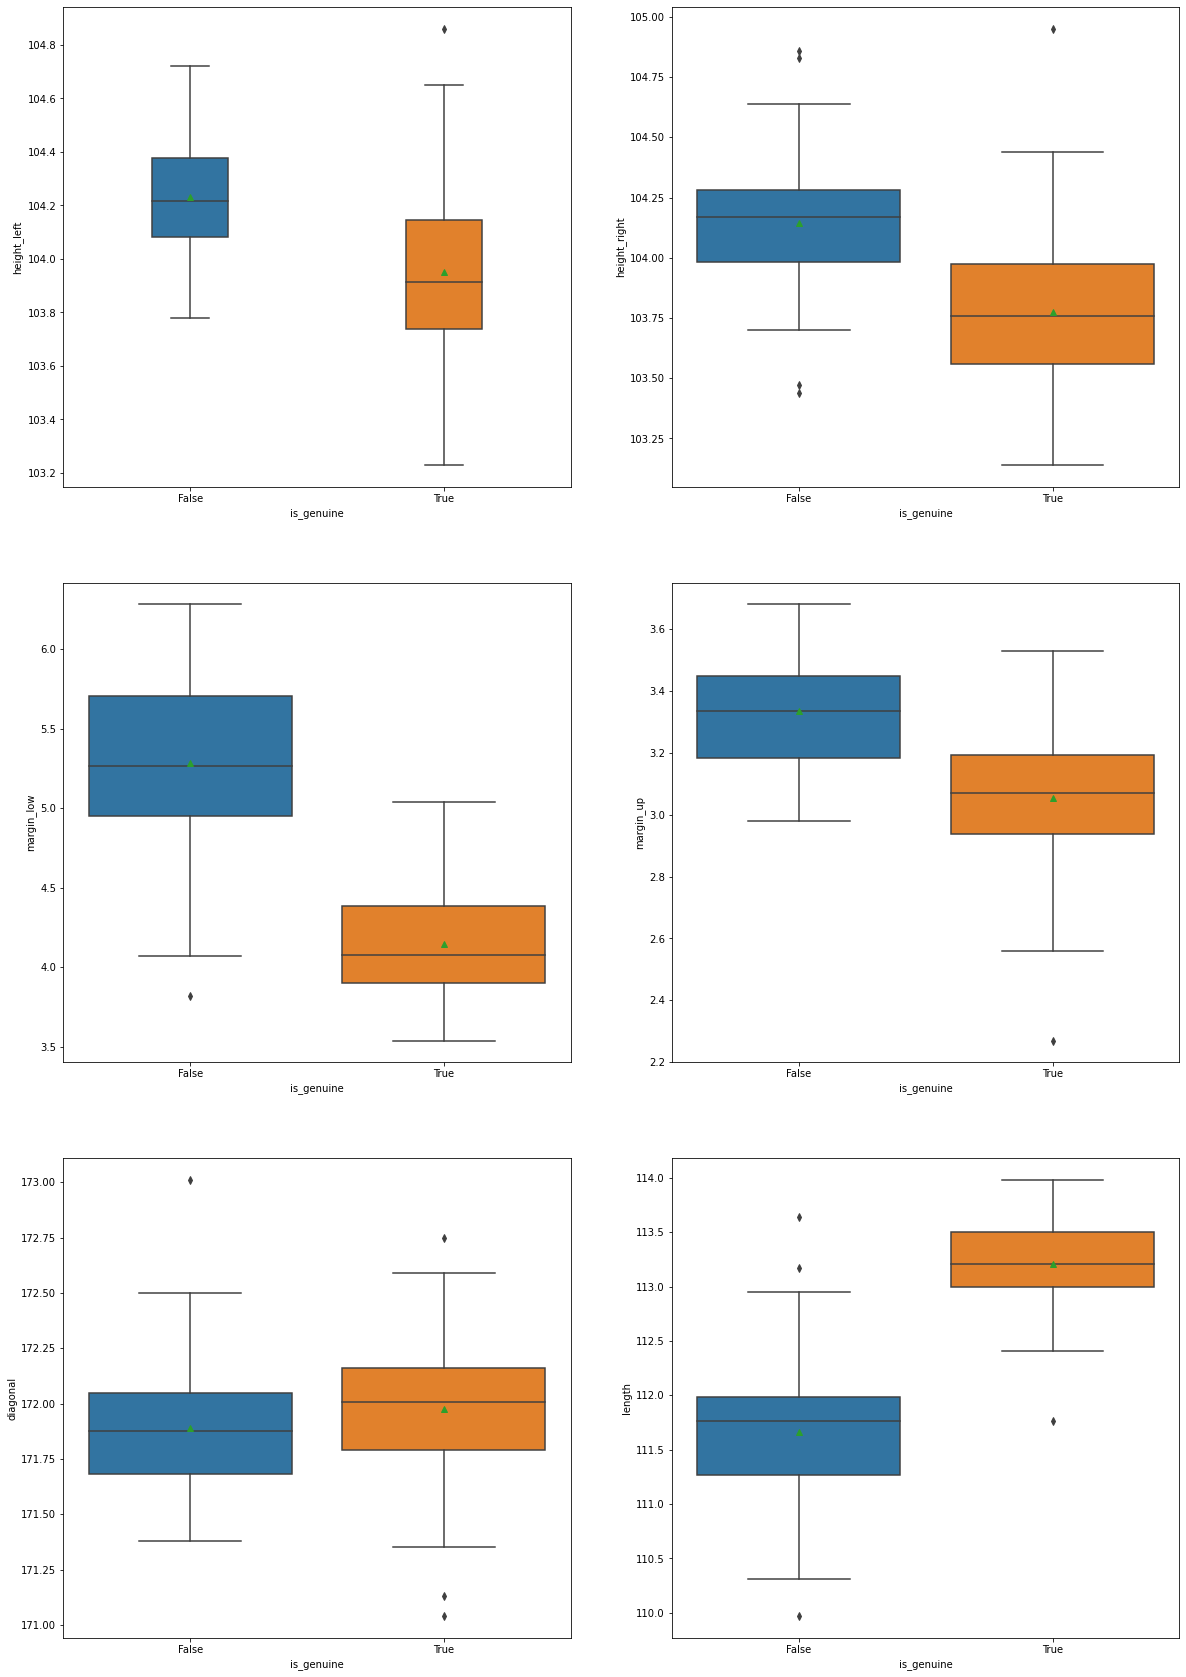

In [438]:
plt.figure(figsize=(20, 30))


plt.subplot(321)
sns.boxplot(x='is_genuine', y='height_left', width=0.3, data=data, showmeans=True)

plt.subplot(322)
sns.boxplot(x='is_genuine', y='height_right', data=data, showmeans=True)

plt.subplot(323)
sns.boxplot(x='is_genuine', y='margin_low', data=data, showmeans=True)

plt.subplot(324)
sns.boxplot(x='is_genuine', y='margin_up', data=data, showmeans=True)

plt.subplot(325)
sns.boxplot(x='is_genuine', y='diagonal', data=data, showmeans=True)

plt.subplot(326)
sns.boxplot(x='is_genuine', y='length', data=data, showmeans=True)




plt.show()

Un premier constat peut-être fait :

les métriques 'margin' et 'height' ont des moyennes et médianes plus élevées pour les faux billets.

la métrique 'length' a une moyenne et médiane plus basse pour les faux billets.

la métrique 'diagonal' ne semble pas être significative.

Des outliers sont visibles, mais restent relativement proches des queues de distribution. Ces valeurs restent totalement acceptables, elles ne semblent pas représenter d'erreur particulière. Ces outliers seront conservés pour la suite de l'analyse.

In [439]:
# billets qui ont valeurs aberrante

print(df[df.height_left>104.8][df.is_genuine==True]) # billet 0

print(df[df.height_right>104.9][df.is_genuine==True]) # billet 0

print(df[df.height_right>104.75][df.is_genuine==False]) # billet 122 

print(df[df.height_right<103.50][df.is_genuine==False]) # billets 141 et 152

print(df[df.margin_low<3.9][df.is_genuine==False]) # billets 160

print(df[df.margin_up<2.3][df.is_genuine==True]) # billet 4

print(df[df.diagonal>173][df.is_genuine==False]) # billet 166

print(df[df.diagonal>172.70][df.is_genuine==True]) # billet 34

print(df[df.diagonal<171.25][df.is_genuine==True]) # billets 39 et 70

print(df[df.length>113][df.is_genuine==False]) # billets 118 et 145

print(df[df.length<110][df.is_genuine==False]) # billets 118 et 145

print(df[df.length<112][df.is_genuine==True]) # billets 118 et 145

   is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   

   length  
0  112.83  
   is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   

   length  
0  112.83  
     is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
112       False    172.32       104.60        104.83        4.84       3.51   
122       False    172.29       104.72        104.86        5.71       3.16   

     length  
112  112.55  
122  112.15  
     is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
141       False    171.74       103.96        103.47        5.14       3.30   
152       False    171.67       103.79        103.44        5.13       3.32   

     length  
141  111.40  
152  111.47  
     is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
160

sns.pairplot trace l'histogramme de chaque variable quantitative, pour chaque classe de la variable catégorielle is_genuine.

La longueur et la marge basse permettent le mieux de discriminer les vrais billets des faux.

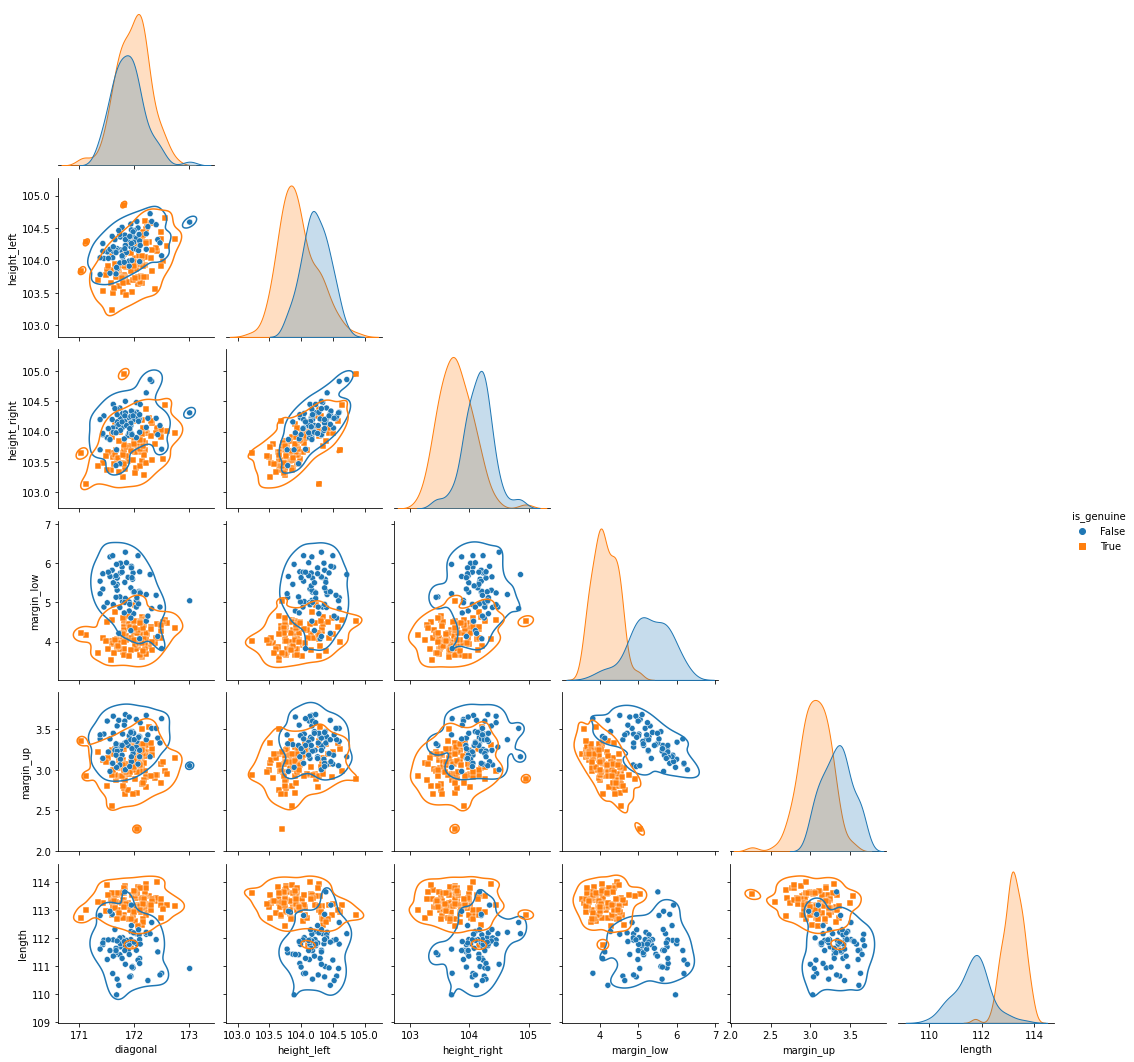

In [440]:
# creation pairplot

c = sns.pairplot(df, hue='is_genuine',markers=['o','s'] ,corner=True)
c.map_lower(sns.kdeplot, levels=2, color='.2')
plt.savefig("P6_02_graphiques/pairplot.jpeg", format='jpg', bbox_inches='tight')

plt.show()

Avec pairplot nous pouvons voir relation entre variables. Par example height_left et diagonal sont positivement corrélées. Donc si une valeur augmente, l'autre va augmenter.

Nous observons qu'il y a une corrélation entre margin_up avec height_left et height_right.

Les faux billets sont plus courts que les vrais, et leur marge basse est à l'inverse nettement plus longue.

Avec pairplot comme ça on observe distibution notre billets vrais et faux.

In [441]:
#Matrice des corrélations linéaires par l'utilisation de la méthode .corr()
data.iloc[:, 1:].corr()

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.000000,0.319584,0.220418,-0.181020,-0.027366,0.080295
height_left,0.319584,1.000000,0.734390,0.424530,0.324788,-0.421387
height_right,0.220418,0.734390,1.000000,0.509375,0.366918,-0.417021
margin_low,-0.181020,0.424530,0.509375,1.000000,0.171113,-0.637352
margin_up,-0.027366,0.324788,0.366918,0.171113,1.000000,-0.525284
length,0.080295,-0.421387,-0.417021,-0.637352,-0.525284,1.000000


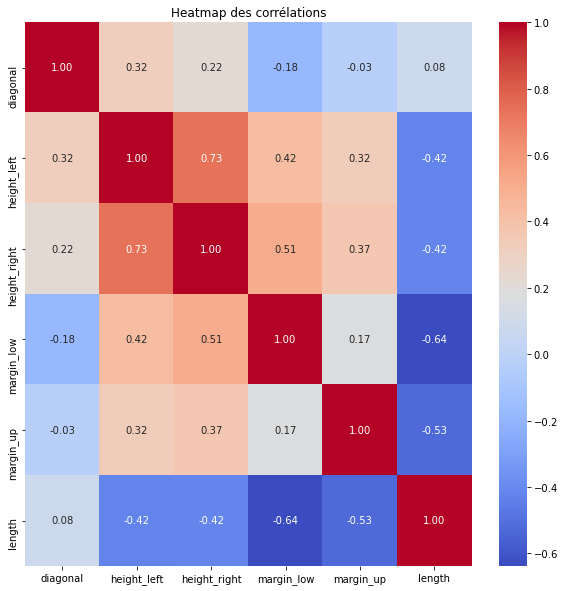

In [442]:
#HeatMap des corrélations linéaires à partir de la matrice précédente
plt.figure(figsize=(10, 10))
sns.heatmap(data.iloc[:, 1:].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.savefig("P6_02_graphiques/Heatmap des corrélations.jpeg", format='jpg', bbox_inches='tight')
plt.title('Heatmap des corrélations')

plt.show()

Observations:

D'après le tableau de contingence coloré ci-dessus, on peut estimer une corrélation positive très forte entre height_right et height_left ( 0.73 ) La valeur obtenue est proche de 1, il existe donc une réelle corrélation linéaire entre ces deux variables. Concrètement, au plus 'height_left' aura une valeur élevée, au plus 'height_right' le sera aussi.On peut estimer une corrélation positive 0.42 entre margin_low et height_left.

On distingue une corrélation négative entre margin_low et la variable length ( -0.64 ). Ceci signifie que quand la valeur d'une variable augmente, la valeur de l'autre variable diminue.

In [443]:
df.corr(method='pearson')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.139223,-0.461730,-0.551309,-0.800111,-0.582801,0.825743
diagonal,0.139223,1.000000,0.319584,0.220418,-0.181020,-0.027366,0.080295
height_left,-0.461730,0.319584,1.000000,0.734390,0.424530,0.324788,-0.421387
height_right,-0.551309,0.220418,0.734390,1.000000,0.509375,0.366918,-0.417021
margin_low,-0.800111,-0.181020,0.424530,0.509375,1.000000,0.171113,-0.637352
margin_up,-0.582801,-0.027366,0.324788,0.366918,0.171113,1.000000,-0.525284
length,0.825743,0.080295,-0.421387,-0.417021,-0.637352,-0.525284,1.000000


Les coefficients de Pearson (r) ci-dessus nous montrent plusieures corrélations linéaires assez fortes :

height_right / height_left avec r = 0.73

height_right / margin_low avec  r = 0.51
 
margin_low / length avec  r = -0.64
margin_up / length avec   r = - 0.52

Très intéressant également, la variable "vrai/faux billet" (is_genuine) semble être très corrélé avec :

margin_low avec r = -0.80
length avec     r = 0.82


___


# Analyse en composantes principales de l'échantillon, en suivant les étapes ci-dessous

L’enjeu d’une ACP est de trouver le meilleur plan de projection ayant la plus grande inertie, c’est à dire limitant le plus la perte d’information originelle. 

Le rôle de l’ACP est de :

Visualiser les relations entre variables à l’aide d’un cercle de corrélation.

Comme précédemment, une ACP ne peut se faire que si les données sont centrées et réduites (transformation pour que moyenne = 0, écart-type = 1).

Nous allons dans un premier temps faire un éboulis des valeurs propre, pour voir combien d'axes étudier.

# Préparation du jeu de données - ACP

In [444]:
# Importation des librairies utilisées

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [445]:
# importation du fichier source
dataset = pd.read_csv("billet.csv", sep=",", decimal=".", header=0)
dataset.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


La variable donnant la nature Vrai/Faux du billet (is_genuine) sera utilisée comme variable illustrative. Nous la retirons donc de la matrice des variables analysées par ACP pour ne pas fausser les calculs.

In [446]:
acp_dataset = dataset.iloc[:, 1:]

#nombre d'observations 
n = acp_dataset.shape[0] 
#nombre de variables / dimenssions
p = acp_dataset.shape[1]

L'ACP est sensible aux valeurs des variables. Il a tendance à donner plus de poids aux variables qui ont des valeurs plus importantes comparés aux variables qui ont des valeurs moins importantes. C'est pour cette raison qu'on standardise notre dataframe, afin qu'on donne la même importance à toutes les variables.

In [447]:
#instanciation 
sc = StandardScaler() 
#transformation – centrage-réduction 
Z = sc.fit_transform(acp_dataset) 
print(Z)

[[-0.42834385  2.6694537   3.09656321 -0.13159013 -1.18987367  0.28163308]
 [-0.88755932 -1.09769709 -0.69125444 -0.86012554 -1.27473985  0.78069736]
 [-0.36274164 -1.03042654 -0.50943919 -0.30301023 -1.23230676  1.37740465]
 ...
 [ 1.73652911  0.68497248  0.52084721  0.38267015  0.67718214 -2.05094997]
 [-0.39554274 -0.32408577 -0.1458087   0.16839504  1.61071005 -0.75989238]
 [ 0.06367273 -0.22317994  0.06630909  1.45404575  0.38015054 -1.74717171]]


In [448]:
#instanciation de l'ACP 
acp = PCA(svd_solver='full')
print(acp)

PCA(svd_solver='full')


In [449]:
#calculs des coordonnées factorielles dans la variable coord 
coord = acp.fit_transform(Z) 
#nombre de composantes calculées 
print(acp.n_components_)

6


# Eboulis des valeurs propres

In [450]:
#variance expliquée 
valprop = acp.explained_variance_
print(valprop)

[2.86372065 1.32522178 0.85912514 0.51460481 0.27840703 0.19442354]


In [451]:
#proportion de variance expliquée 
valprop_ratio = acp.explained_variance_ratio_
print(valprop_ratio)

[0.47447921 0.21957106 0.14234524 0.08526295 0.04612822 0.03221331]


In [452]:
from sklearn.decomposition import PCA

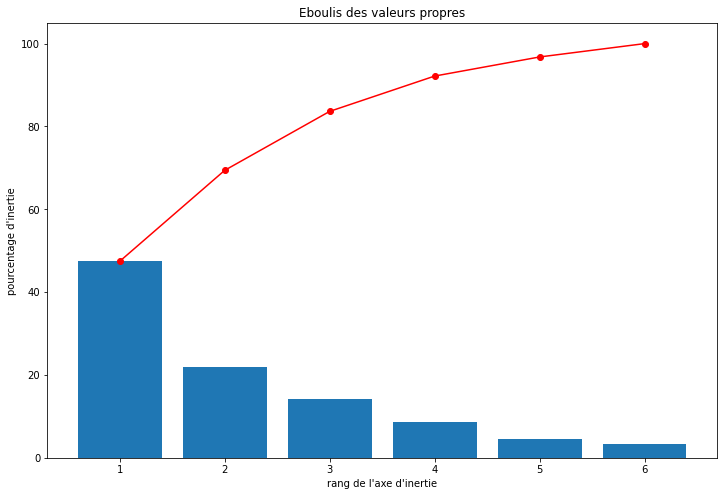

<Figure size 432x288 with 0 Axes>

In [453]:
# Eboulis des valeurs propres
varexpl = valprop_ratio*100
fig = plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)
plt.plot(np.arange(len(varexpl))+1, varexpl.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

plt.savefig("P6_02_graphiques/Scree_plot.jpeg", format='jpg', bbox_inches='tight')

On remarque ici que les 2 premiers axes cumulent 69.40% de l'inertie totale. Une analyse sur  et  semble donc cohérante.

In [454]:
#seuils pour test des bâtons brisés
bs = 1/np.arange(p,0,-1)
bs = np.cumsum(bs)
bs = bs[::-1]

In [455]:
#Variance expliquée corrigée
eigval= (n-1)/n*valprop
eigval

array([2.84687523, 1.31742636, 0.85407146, 0.51157773, 0.27676935,
       0.19327987])

In [456]:
#test des bâtons brisés
print(pd.DataFrame({'Val.Propre':eigval,'Seuils':bs}))

   Val.Propre    Seuils
0    2.846875  2.450000
1    1.317426  1.450000
2    0.854071  0.950000
3    0.511578  0.616667
4    0.276769  0.366667
5    0.193280  0.166667


Le nombre de facteurs en utilisant par défaut le critère de Kaiser (valeurs propres supérieures à 1)

Deux facteurs sont retenus, tel qu’indiqué par la tableau.

In [457]:
# Présentons les deux nouvelles variables créées dans le tableau appelé "composantes":
composantes=pd.DataFrame(coord, index=dataset.index)
composantes.columns=["F1", "F2","F3","F4","F5","F6"] ; composantes.head(4)

,F1,F2,F3,F4,F5,F6
0,2.153639,1.599709,1.787451,2.433465,0.699690,-1.267702
1,-2.110416,-0.526039,0.542563,0.344550,0.067440,-0.544601
2,-1.973152,-0.048102,0.858716,0.374812,-0.424886,0.080487
3,-2.059795,-0.089105,-0.531529,0.519548,-0.033267,-0.038261


# Représentation des variables

# Cercle des corrélations

In [458]:
pcs = acp.components_
print(pcs)

[[ 0.07327499  0.47550205  0.4918214   0.43102671  0.35253984 -0.46537288]
 [ 0.77963908  0.33925019  0.23554253 -0.32053699 -0.14111974  0.31453645]
 [-0.08889419  0.12276016  0.15383022  0.5128076  -0.82114881  0.12691346]
 [-0.55973158  0.2780463   0.45893794 -0.22652773  0.13533955  0.57370304]
 [-0.22509444  0.71592059 -0.48699285 -0.31190784 -0.1939426  -0.25441684]
 [ 0.12216606  0.23213146 -0.4808135   0.54763041  0.35437971  0.52395111]]


In [459]:
sqrt_valprop = np.sqrt(valprop)

In [460]:
#corrélation des variables avec les axes 
corvar = np.zeros((p,p)) 
for k in range(p): 
    corvar[:,k] = acp.components_[k,:] * sqrt_valprop[k] 

#afficher la matrice des corrélations variables x facteurs 
print(corvar)

[[ 0.12399984  0.89750708 -0.08239513 -0.40152883 -0.11876949  0.05386727]
 [ 0.80466983  0.39053898  0.11378517  0.19945918  0.37775042  0.10235485]
 [ 0.83228631  0.2711525   0.14258369  0.32922354 -0.25695832 -0.21200743]
 [ 0.7294063  -0.36899666  0.47531625 -0.16250184 -0.16457596  0.24146933]
 [ 0.59658665 -0.16245462 -0.76111465  0.09708712 -0.10233243  0.15625837]
 [-0.78752871  0.36208895  0.11763482  0.41155139 -0.13424124  0.23102831]]


In [461]:
#on affiche pour les deux premiers axes 
pd.DataFrame({'id':acp_dataset.columns,'COR_F1':corvar[:,0],'COR_F2':corvar[:,1]})

,id,COR_F1,COR_F2
0,diagonal,0.124000,0.897507
1,height_left,0.804670,0.390539
2,height_right,0.832286,0.271153
3,margin_low,0.729406,-0.368997
4,margin_up,0.596587,-0.162455
5,length,-0.787529,0.362089


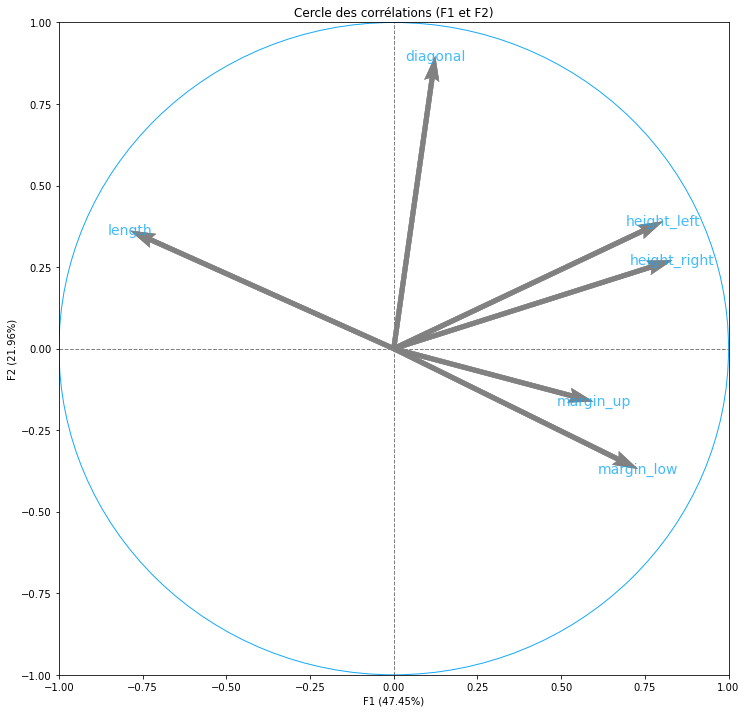

<Figure size 432x288 with 0 Axes>

In [462]:
#cercle des corrélations 
fig, axes = plt.subplots(figsize=(12,12)) 

#détermination des limites du graphique
axes.set_xlim(-1,1) 
axes.set_ylim(-1,1) 

#affichage des flèches et noms de variables 
for j in range(p):
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   corvar[j,0],corvar[j,1], 
                   angles='xy', scale_units='xy', scale=1, color="grey", alpha=0.5)
    plt.annotate(acp_dataset.columns[j],
                     (corvar[j,0],corvar[j,1]),
                     ha='center', va='center',
                     fontsize='14',color="#17aafa", alpha=0.8) 

#ajouter les axes 
plt.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
plt.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

#ajouter un cercle 
cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
axes.add_artist(cercle) 

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F1 ({}%)'.format(round(100*valprop_ratio[0],2)))
plt.ylabel('F2 ({}%)'.format(round(100*valprop_ratio[1],2)))

plt.title("Cercle des corrélations (F1 et F2)")

#affichage 
plt.show()
plt.savefig("P6_02_graphiques/ACP_cercle_correlations.jpeg")

A partir de cette représentation graphique, nous pouvons déterminer les variables qui se révélent être les plus corrélées aux composantes F1 et F2. Notons également que la longueur des flèches est importante, une variable dont la longueur de la flèche est proche de 1 sera extrêmement bien représentée

La variable diagonal contribue fortement (et positivement) à l'axe 2

Les variables height_left et height_right contribuent le plus et positivement à l'axe 1.

Les variables margin_up et margin_low contribuent positivement à l'axe 1.

La variable lenght contribue négativement à l'axe 1.
Corrélation négative entre lenght et margin.

On peut dire que tous variables sont très bien représentée.

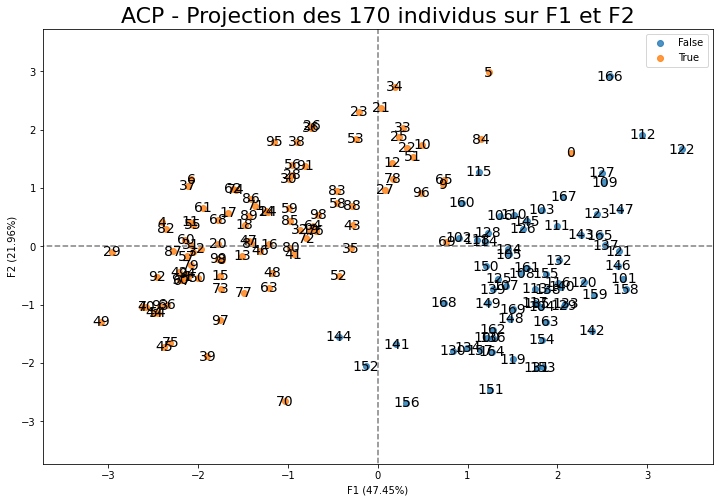

In [463]:
# initialisation de la figure       
fig = plt.figure(figsize=(12,8))

# Affichage des points et variable illustrative
illustrative_var = np.array(dataset['is_genuine'].values)
for value in np.unique(illustrative_var):
    selected = np.where(illustrative_var == value)
    plt.scatter(coord[selected, 0], coord[selected, 1], alpha=0.8, label=value)
    plt.legend()

# affichage des labels des points
for i,(x,y) in enumerate(coord[:,[0,1]]):
    plt.text(x, y, acp_dataset.index[i], fontsize='14', ha='center',va='center')
    
# détermination des limites du graphique
boundary = np.max(np.abs(coord[:, [0,1]])) * 1.1
plt.xlim([-boundary,boundary])
plt.ylim([-boundary,boundary])
        
# affichage des lignes horizontales et verticales
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F1 ({}%)'.format(round(100*valprop_ratio[0],2)))
plt.ylabel('F2 ({}%)'.format(round(100*valprop_ratio[1],2)))


plt.savefig("P6_02_graphiques/ACP - Projection des {} individus sur F1 et F2.jpeg", format='jpg', bbox_inches='tight')

plt.title("ACP - Projection des {} individus sur F1 et F2".format(coord.shape[0]), fontsize=22)
plt.show(block=False)

Le premier plan factoriel est de loin le plus représentatif pour pouvoir effectuer une projection des variables et des individus, les autres composantes principales n'ont pas besoin d'être traitées.



 Interprétation des projections réalisées : \ F1 : représente la longueur du billet / hauteur ainsi que la marge \ F2 : représente la longueur de la diagonale

L'axe de la première composante est celui qui sépare principalement les vrais billets des faux billets. De plus, F1 explique 47% de l'inertie. Sur la plupart des observations F1 permet l'identification des billets. Concernant les valeurs proches de zéro, c'est F2 qui permet de discriminer.

Le second axe explique 22% de l'inertie et participe à la séparation des vrais billets et des faux billets.

On voit qu'une diagonale sépare clairement les vrais et les faux billets.


# Qualité de représentation des variables (COS²)

On peut calculer la qualité de représentation des variables en élevant la corrélation au carré :

In [464]:
cos2var = corvar**2 
df_cos2var = pd.DataFrame({'id':acp_dataset.columns,'COS2_F1':cos2var[:,0],'COS2_F2':cos2var[:,1]})
df_cos2var = df_cos2var.set_index('id')

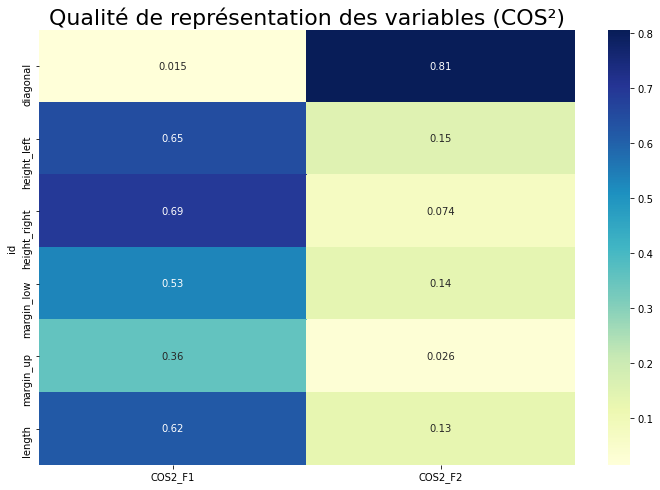

In [465]:
#affichage dans un heatmap seaborn
fig = plt.figure(figsize=(12,8))
sns.heatmap(df_cos2var, annot=True, cmap="YlGnBu")
plt.title("Qualité de représentation des variables (COS²)", fontsize=22)
plt.savefig("P6_02_graphiques/Qualité de représentation des variables (COS²).jpeg", format='jpg', bbox_inches='tight')
plt.show()

On remarque ici clairement, avec le cercle et le COS², les corrélations importantes entre les hauteurs de billet notamment ou encore les marges. Ce qui semble relativement normal. L'axe F1 va donc parfaitement représenter le facteur "dimenssions globales" et l'axe F2 quant à lui représentera bien les variables de "diagonale".

# Contribution des variables aux axes (CTR)

La contribution est également basée sur le carré de la corrélation, mais relativisée par l’importance de l’axe :

In [466]:
#contributions 
ctrvar = cos2var 
for k in range(p): 
    ctrvar[:,k] = ctrvar[:,k]/valprop[k] 

#on n'affiche que pour les deux premiers axes 
df_ctrvar = pd.DataFrame({'id':acp_dataset.columns,'CTR_F1':ctrvar[:,0],'CTR_F2':ctrvar[:,1]})
df_ctrvar = df_ctrvar.set_index('id')

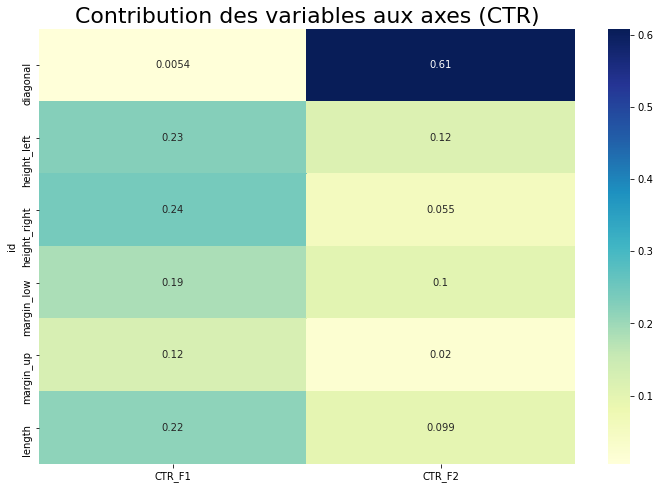

In [467]:
#affichage dans un heatmap seaborn
fig = plt.figure(figsize=(12,8))
sns.heatmap(df_ctrvar, annot=True, cmap="YlGnBu")
plt.title("Contribution des variables aux axes (CTR)", fontsize=22)
plt.savefig("P6_02_graphiques/Contribution des variables aux axes (CTR).jpeg", format='jpg', bbox_inches='tight')
plt.show()

Les variables qui contribuent le mieux à l’inertie des axes,

c’est-à-dire celles expliquent plus de

= 100/ Nombre de variables % = 16.7 % de l’inertie totale.

Donc on peut dire tous les variables au_dessus de 16%.

On voit que les variables qui ont le plus de contribution à F1 sont height_right et height_left, puis length ensuite. La variable qui contribue très fortement à F2 est bien diagonal

In [468]:
viGenuine = dataset['is_genuine'].values 
print(viGenuine)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [469]:
viGenuine = viGenuine.reshape((viGenuine.shape[0],1))
viGenuine.shape

(170, 1)

In [470]:
#corrélation avec les axes factoriels 
corSupp = np.zeros((viGenuine.shape[1],p))
for k in range(p): 
    for j in range(viGenuine.shape[1]): 
        corSupp[j,k] = np.corrcoef(viGenuine[:,j],coord[:,k])[0,1] 

#affichage des corrélations avec les axes 
print(corSupp)

[[-0.83869593  0.36633913  0.02077017  0.16326643  0.11232141 -0.08449246]]


# Représentation des individus


Les coordonnées factorielles des individus ont été stockées dans la variable coord. Nous les positionnons dans le premier plan factoriel avec leurs labels et colorons les points en fonction de la variable illustrative is_genuine.

# Projection des individus sur le plan factoriel

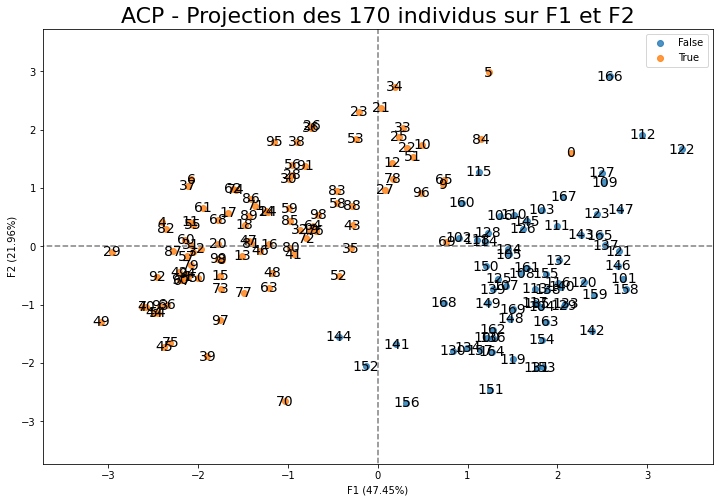

In [471]:
# initialisation de la figure       
fig = plt.figure(figsize=(12,8))

# Affichage des points et variable illustrative
illustrative_var = np.array(dataset['is_genuine'].values)
for value in np.unique(illustrative_var):
    selected = np.where(illustrative_var == value)
    plt.scatter(coord[selected, 0], coord[selected, 1], alpha=0.8, label=value)
    plt.legend()

# affichage des labels des points
for i,(x,y) in enumerate(coord[:,[0,1]]):
    plt.text(x, y, acp_dataset.index[i], fontsize='14', ha='center',va='center')
    
# détermination des limites du graphique
boundary = np.max(np.abs(coord[:, [0,1]])) * 1.1
plt.xlim([-boundary,boundary])
plt.ylim([-boundary,boundary])
        
# affichage des lignes horizontales et verticales
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F1 ({}%)'.format(round(100*valprop_ratio[0],2)))
plt.ylabel('F2 ({}%)'.format(round(100*valprop_ratio[1],2)))

plt.title("ACP - Projection des {} individus sur F1 et F2".format(coord.shape[0]), fontsize=22)

plt.savefig("P6_02_graphiques/Projection des individus sur F1 et F2.jpeg", format='jpg', bbox_inches='tight')
plt.show(block=False)

Les 2 nuages de points en fonction de la variable "vrai / faux billet" sont ici clairement identifiés grâce à cette projection sur le premier plan factoriel F1 / F2 . Testons à présent la qualité de la représentation.

# Qualité de représentation des individus (COS²)

Calculons les carrés des distances à l’origine des individus, qui correspondent également à leur contribution dans l’inertie totale :

In [472]:
#contribution des individus dans l'inertie totale 
di = np.sum(Z**2,axis=1) 
df_contind = pd.DataFrame({'ID':acp_dataset.index,'d_i':di})
df_contind = df_contind.sort_values("d_i", ascending=False)
df_contind

,ID,d_i
166,166,20.625650
0,0,18.410598
4,4,18.039567
122,122,16.790944
39,39,15.052608
...,...,...
59,59,1.484454
76,76,1.435202
85,85,1.431664
98,98,0.878319


On remarque que certains individus (166, 0, 4 ...) contribuent fortement à l'inertie totale. Sur la projection graphique, on les retrouve bien aux extrémités du plan factoriel pour leur catégorie.

Nous pouvons à présent calculer la qualité de représentation sur les axes  F1 et F2 :

In [473]:
#qualité de représentation des individus - COS2 
cos2 = coord**2 
for j in range(p): 
    cos2[:,j] = cos2[:,j]/di 

df_cos2ind = pd.DataFrame({'id':acp_dataset.index,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1]})
df_cos2ind

,id,COS2_F1,COS2_F2
0,0,0.251929,0.139000
1,1,0.818002,0.050822
2,2,0.784862,0.000466
3,3,0.882856,0.001652
4,4,0.320145,0.009417
...,...,...,...
165,165,0.800651,0.004703
166,166,0.324059,0.411824
167,167,0.498809,0.083461
168,168,0.156908,0.271800


On peut représenter graphiquement le COS² sur F1 par exemple en determinant la taille des points en fonction de leur qualité de représentation ;

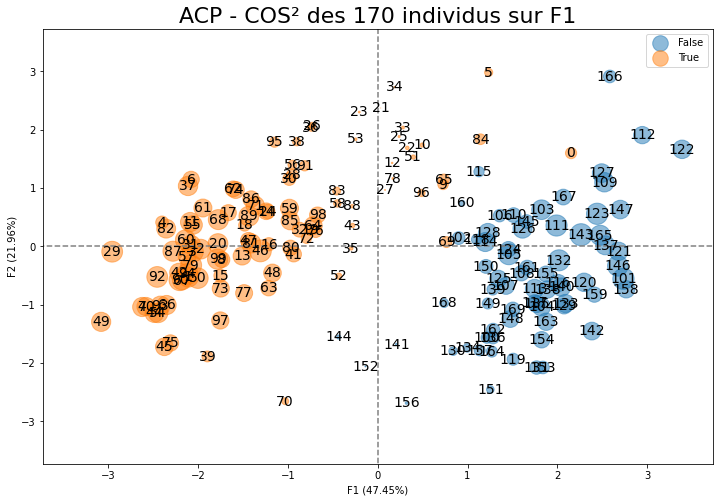

In [474]:
fig = plt.figure(figsize=(12,8))

# Affichage des points et variable illustrative
illustrative_var = np.array(dataset['is_genuine'].values)
for value in np.unique(illustrative_var):
    selected = np.where(illustrative_var == value)
    plt.scatter(coord[selected, 0], coord[selected, 1], alpha=0.5, label=value, marker='o', 
                s=(cos2[selected, 0]*500))
    plt.legend()

# affichage des labels des points
for i,(x,y) in enumerate(coord[:,[0,1]]):
    plt.text(x, y, acp_dataset.index[i], fontsize='14', ha='center',va='center')
    
# détermination des limites du graphique
boundary = np.max(np.abs(coord[:, [0,1]])) * 1.1
plt.xlim([-boundary,boundary])
plt.ylim([-boundary,boundary])
        
# affichage des lignes horizontales et verticales
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F1 ({}%)'.format(round(100*valprop_ratio[0],2)))
plt.ylabel('F2 ({}%)'.format(round(100*valprop_ratio[1],2)))

plt.title("ACP - COS² des {} individus sur F1".format(coord.shape[0]), fontsize=22)
plt.savefig("P6_02_graphiques/ACP - COS² des individus sur F1.jpeg", format='jpg', bbox_inches='tight')
plt.show(block=False)

Il est judicieux de remarquer, du moins de prêter attention aux points dont la contribution est supérieure à la moyenne, car se sont ces individus qui permettent de donner un sens à l’axe. De plus, une contribution trop importante d’un des points à un axe doit être regardé avec prudence.

Ce scatter plot sur le premier plan factoriel nous démontre que les individus sont relativement très bien représentés. En effet, un individu mal représenté sera proche de l'origine, avec par conséquent peu de contribution à la formation des axes étudiés. Ici, ce n'est pas le cas, on distingue parfaitement deux groupes d'individus, avec un large espace proche de l'origine.

# Contribution des individus aux axes (CTR)

Nous pouvons déterminer les individus qui influent le plus dans la définition de chaque facteur :

In [475]:
#contributions aux axes 
ctr = coord**2 
for j in range(p): 
    ctr[:,j] = ctr[:,j]/(n*valprop[j]) 
    
df_ctrind = pd.DataFrame({'id':acp_dataset.index,'CTR_F1':ctr[:,0],'CTR_F2':ctr[:,1]})
df_ctrind

,id,CTR_F1,CTR_F2
0,0,0.009527,0.011359
1,1,0.009149,0.001228
2,2,0.007997,0.000010
3,3,0.008715,0.000035
4,4,0.011863,0.000754
...,...,...,...
165,165,0.012620,0.000160
166,166,0.013729,0.037704
167,167,0.008778,0.003174
168,168,0.001123,0.004202


In [476]:
#Individus déterminants sur F1 
df_ctrind[['id','CTR_F1']].sort_values('CTR_F1', ascending=False)

,id,CTR_F1
122,122,0.023618
49,49,0.019505
29,29,0.017982
112,112,0.017845
158,158,0.015743
...,...,...
78,78,0.000059
12,12,0.000053
152,152,0.000038
27,27,0.000014


In [477]:
#Individus déterminants sur F2 
df_ctrind[['id','CTR_F2']].sort_values('CTR_F2', ascending=False)

,id,CTR_F2
5,5,0.039503
166,166,0.037704
34,34,0.033106
156,156,0.032074
70,70,0.031331
...,...,...
16,16,0.000006
35,35,0.000005
31,31,0.000003
80,80,0.000003


Grâce à ces CTR, nous pouvons déterminer les individus qui pèsent le plus sur les axes F1 et F2. Nous n'avons pas d'individus clairement influent sur chaque axe.

F1  des billets 122,49,29,112,158

F2 des billets 5,166,34,156,70

In [478]:
#calcul des coordonnées des centroides
df_centroides = pd.DataFrame({'Test':dataset['is_genuine'],'F1':coord[:,0],'F2':coord[:,1]})  
df_centroides = df_centroides.pivot_table(index='Test',values=['F1','F2'],aggfunc=pd.Series.mean)
df_centroides

,F1,F2
Test,,
False,1.691374,-0.502571
True,-1.183962,0.351800


In [479]:
df_centroides.to_csv("P6_03_centroides.csv") 


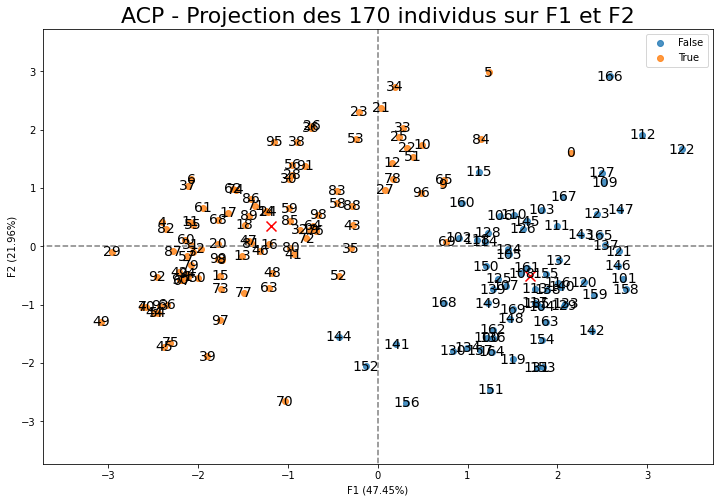

In [480]:
# initialisation de la figure       
fig = plt.figure(figsize=(12,8))

# Affichage des points et variable illustrative
illustrative_var = np.array(dataset['is_genuine'].values)
for value in np.unique(illustrative_var):
    selected = np.where(illustrative_var == value)
    plt.scatter(coord[selected, 0], coord[selected, 1], alpha=0.8, label=value)
    plt.legend()

# affichage des labels des points
for i,(x,y) in enumerate(coord[:,[0,1]]):
    plt.text(x, y, acp_dataset.index[i], fontsize='14', ha='center',va='center')
    
# affichage des centroides sur is_genuine
for j,(x1,y1) in df_centroides.iterrows():
    plt.scatter(x1,y1, c = 'red', marker='x', s=100, label="Centroides")
      
# détermination des limites du graphique
boundary = np.max(np.abs(coord[:, [0,1]])) * 1.1
plt.xlim([-boundary,boundary])
plt.ylim([-boundary,boundary])
        
# affichage des lignes horizontales et verticales
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F1 ({}%)'.format(round(100*valprop_ratio[0],2)))
plt.ylabel('F2 ({}%)'.format(round(100*valprop_ratio[1],2)))

plt.title("ACP - Projection des {} individus sur F1 et F2".format(coord.shape[0]), fontsize=22)
plt.savefig("P6_02_graphiques/ACP - Projection des individus sur F1 et F2.jpeg", format='jpg', bbox_inches='tight')
plt.show(block=False)

L'ACP discrimine bien les billets en 2 groupes (les authentiques et les falsifiés). Seuls quelques points sont à l'interface des 2 groupes (par exemple : billets n°0, 69, 70 , 115, 166) et pourraient poser problème pour les missions suivantes.

In [481]:
# union data et composantes
final = pd.merge(dataset,composantes,left_index=True, right_index=True)

final

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,F3,F4,F5,F6
0,True,171.81,104.86,104.95,4.52,2.89,112.83,2.153639,1.599709,1.787451,2.433465,0.699690,-1.267702
1,True,171.67,103.74,103.70,4.01,2.87,113.29,-2.110416,-0.526039,0.542563,0.344550,0.067440,-0.544601
2,True,171.83,103.76,103.76,4.40,2.88,113.84,-1.973152,-0.048102,0.858716,0.374812,-0.424886,0.080487
3,True,171.80,103.78,103.65,3.73,3.12,113.63,-2.059795,-0.089105,-0.531529,0.519548,-0.033267,-0.038261
4,True,172.05,103.70,103.75,5.04,2.27,113.55,-2.403180,0.412170,3.319507,-0.837043,-0.420151,-0.445099
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78,2.478626,0.189974,-0.814598,0.107861,-0.899828,0.093078
166,False,173.01,104.59,104.31,5.04,3.05,110.91,2.585331,2.914472,0.586789,-2.183704,0.274577,-0.509206
167,False,172.47,104.27,104.10,4.88,3.33,110.68,2.067245,0.845602,-0.610282,-1.714172,0.116958,-0.504338
168,False,171.82,103.97,103.88,4.73,3.55,111.87,0.739257,-0.972965,-1.359772,-0.191736,-0.243557,0.211429


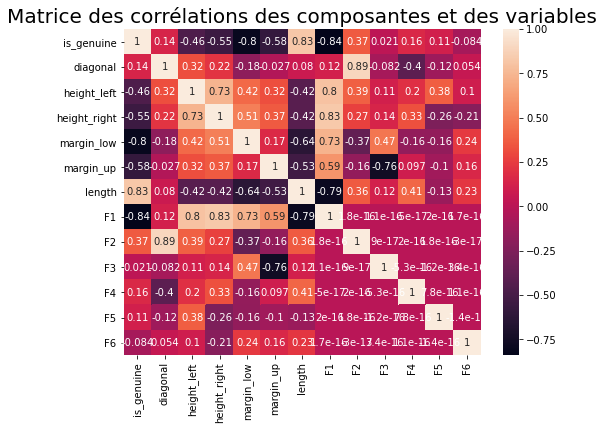

<Figure size 432x288 with 0 Axes>

In [482]:
plt.figure(figsize=(8, 6))

sns.heatmap(final.corr(), annot=True)
plt.title("Matrice des corrélations des composantes et des variables", fontsize=20) ; plt.show()
plt.savefig("P6_02_graphiques/Matrice des corrélations des composantes et des variables.jpeg", format='jpg', bbox_inches='tight')

La variable diagonal contribue le plus et positivement à l'axe 2 (coef. de corrélation de 0.89)

Les variables height_left et height_right contribuent le plus et positivement à l'axe 1 (coef. de corrélation de, respectivement, 0.8 et 0.83).

La variable lenght contribue négativement à l'axe 1 (coef. de corrélation de -0.79).



# Classification par l'algorithme K-Means (centres mobiles)

Choix du nombre du cluster :

Le contexte métier nous oriente naturellement vers un k=2, traçons l'inertie pour vérifier que le k=2 est bien la solution optimale.

In [483]:

from sklearn import metrics

Méthode des silhouettes pour déterminer le meilleur K
Nous allons faire varier le nombre de clusters de 2 à 15 avec la méthode des silhouettes. La variable Z contient les données centrées réduites du dataframe initial SANS la variable is_genuine.

In [484]:
res = np.arange ( 14, dtype ="double" )
for k in np.arange(14):
    kms = KMeans(n_clusters = k+2)
    kms.fit(Z)
    res[k] = metrics.silhouette_score(Z, kms.labels_)
print(res)

[0.35208337 0.30007664 0.25460062 0.197422   0.20648793 0.21130669
 0.18803599 0.18833569 0.197995   0.19107698 0.18393314 0.18924521
 0.16854038 0.16454412]


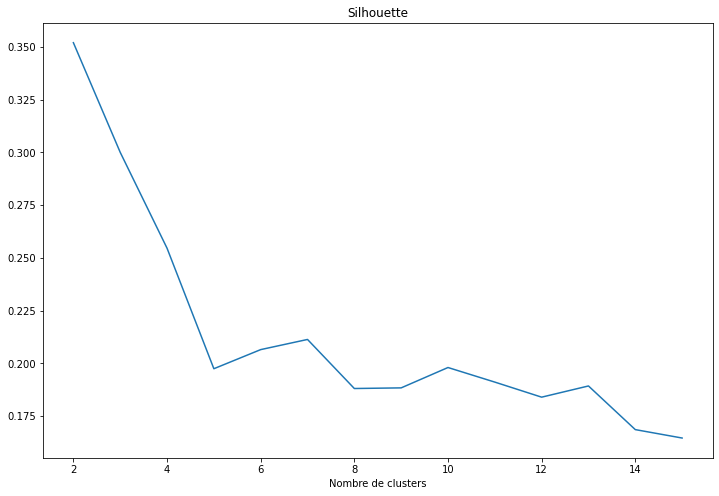

In [485]:
fig = plt.figure(figsize=(12,8))
plt.title("Silhouette")
plt.xlabel("Nombre de clusters")
plt.plot(np.arange(2,16,1), res)

plt.savefig("P6_02_graphiques/Silhouette.jpeg", format='jpg', bbox_inches='tight')
plt.show()


On remarque donc que l'algorithme en 2K sera parfaitement pertinent, ce d'autant que nous cherchons à classifier nos données sur le résultat "vrai" ou "faux".

In [486]:
# Nombre de clusters souhaités
n_clust = 2
# Clustering par K-means avec librairie sklearn sur les données centrées réduites
km = KMeans(n_clusters=n_clust)
km.fit(Z)

KMeans(n_clusters=2)

In [487]:
# Récupération des clusters attribués à chaque individu
clusters_km = km.labels_
clusters_km

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Nous allons ajouter ces clusters au dataset initial pour pouvoir les comparer avec la variable is_genuine :

In [488]:
dataset['Cluster'] = clusters_km

In [489]:
dataset.sample(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Cluster
6,True,172.38,103.55,103.80,3.97,2.90,113.30,0
169,False,171.96,104.00,103.95,5.63,3.26,110.96,1
167,False,172.47,104.27,104.10,4.88,3.33,110.68,1
166,False,173.01,104.59,104.31,5.04,3.05,110.91,1
84,True,172.30,104.58,104.17,4.36,3.33,112.98,1
152,False,171.67,103.79,103.44,5.13,3.32,111.47,1
8,True,171.96,103.51,103.75,4.06,3.33,113.53,0
162,False,171.67,104.12,103.98,5.68,3.18,111.55,1
148,False,171.67,104.16,104.08,5.42,3.30,111.63,1
146,False,171.98,104.44,104.26,5.75,3.20,110.93,1


# Comparaison Kmeans / is_genuine

In [490]:
# Repérer le Cluster kmeans correspondant à is_genuine = False
cross_kmeans = pd.crosstab(dataset['Cluster'], dataset['is_genuine']).reset_index()
cluster_false = cross_kmeans[cross_kmeans[False] > cross_kmeans[True]].Cluster

In [491]:
#affichage des différences
df_diff = dataset[((dataset['is_genuine'] == True) & (dataset['Cluster'] == int(cluster_false))) | ((dataset['is_genuine'] == False) & (dataset['Cluster'] != int(cluster_false)))]
df_diff

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Cluster
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1
5,True,172.57,104.65,104.44,4.54,2.99,113.16,1
9,True,172.14,104.34,104.20,4.63,3.02,112.47,1
65,True,172.16,104.43,104.06,4.51,3.19,112.69,1
69,True,171.94,104.11,104.16,4.08,3.35,111.76,1
84,True,172.30,104.58,104.17,4.36,3.33,112.98,1
96,True,172.00,104.32,104.26,4.53,3.04,112.93,1
144,False,171.56,103.80,103.87,5.66,2.98,112.95,0


In [492]:
print("Nous avons donc une marge d'erreur de",round((df_diff.shape[0]/n)*100,2),"% sur nos",n,"individus.")

Nous avons donc une marge d'erreur de 4.71 % sur nos 170 individus.


# Projection sur le plan factoriel

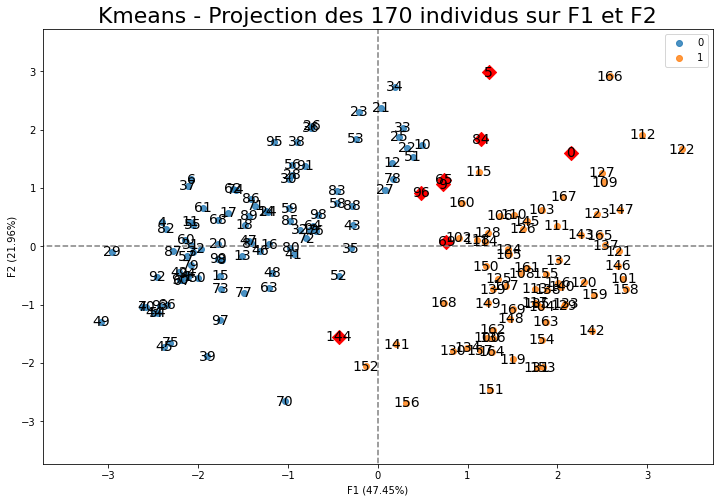

<Figure size 432x288 with 0 Axes>

In [493]:
# initialisation de la figure       
fig = plt.figure(figsize=(12,8))

# Affichage des points et variable illustrative
illustrative_var = np.array(dataset['Cluster'].values)
for value in np.unique(illustrative_var):
    selected = np.where(illustrative_var == value)
    plt.scatter(coord[selected, 0], coord[selected, 1], alpha=0.8, label=value)
    plt.legend()

# affichage des labels des points
for i,(x,y) in enumerate(coord[:,[0,1]]):
    plt.text(x, y, acp_dataset.index[i], fontsize='14', ha='center',va='center')
    
#Affichage des points différents
for ind in df_diff.iterrows():
    plt.scatter(coord[ind[0],0], coord[ind[0],1], alpha=1, marker="D", s=100, color="r")
      
# détermination des limites du graphique
boundary = np.max(np.abs(coord[:, [0,1]])) * 1.1
plt.xlim([-boundary,boundary])
plt.ylim([-boundary,boundary])
        
# affichage des lignes horizontales et verticales
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F1 ({}%)'.format(round(100*valprop_ratio[0],2)))
plt.ylabel('F2 ({}%)'.format(round(100*valprop_ratio[1],2)))

plt.title("Kmeans - Projection des {} individus sur F1 et F2".format(coord.shape[0]), fontsize=22)
plt.show(block=False)
plt.savefig("P6_02_graphiques/Kmeans_Projection des individus sur F1 et F2.jpeg", format='jpg', bbox_inches='tight')

Les losanges rouges représentent les différences Kmeans avec la variable is_genuine. Majoritairement, il s'agit de vrais billets qui sont considérés comme faux dans la classification Kmeans. On remarque que ces points sont assez centraux et éloignés de leurs centroïdes respectifs.

In [494]:
df_inertie = pd.DataFrame(km.transform(Z), index=dataset.index, columns=["I0","I1"])
df_inertie_diff = df_inertie[df_inertie.index.isin(df_diff.index.to_list())]
df_inertie_diff

,I0,I1
0,4.991269,3.941603
5,3.889395,3.499126
9,2.370231,1.878485
65,2.330690,1.847197
69,2.512500,1.683233
84,3.101858,2.451985
96,2.204027,2.047235
144,2.636674,2.961691


En affichant les distances aux centroïdes de ces individus, on remarque qu'ils sont relativement proches I0 sur I1  et . Mais on ne peut pas prendre ce critère pour les caractériser car c'est aussi le cas d'autres points qui eux sont bien catégorisés :

In [495]:
df_inertie_diff["ecart"] = abs(df_inertie_diff["I0"] - df_inertie_diff["I1"])
df_inertie_diff

,I0,I1,ecart
0,4.991269,3.941603,1.049666
5,3.889395,3.499126,0.390268
9,2.370231,1.878485,0.491746
65,2.330690,1.847197,0.483493
69,2.512500,1.683233,0.829268
84,3.101858,2.451985,0.649873
96,2.204027,2.047235,0.156793
144,2.636674,2.961691,0.325016


In [496]:
df_inertie[abs(df_inertie["I0"] - df_inertie["I1"]) <= df_inertie_diff["ecart"].max()]

,I0,I1
0,4.991269,3.941603
5,3.889395,3.499126
9,2.370231,1.878485
10,3.024926,3.056272
12,2.659477,2.982944
21,2.598139,3.207075
22,2.433865,2.654026
23,2.538810,3.337672
25,2.751587,3.095021
27,2.343449,2.700608


Nous allons à présent réaliser une modélisation des données afin de créer un programme capable d'effectuer une prédiction sur un billet. Une régression logistique plus précisement car la variable à estimer est de type qualitative binomiale.

In [497]:
df["cluster"]=km.labels_ 

In [498]:
df.sample(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
96,True,172.00,104.32,104.26,4.53,3.04,112.93,1
130,False,171.43,104.14,103.95,5.34,3.14,111.76,1
123,False,172.05,104.60,104.32,5.12,3.35,111.78,1
77,True,171.69,103.85,103.53,3.86,3.19,112.68,0
12,True,172.19,104.61,103.69,4.00,3.26,112.91,0
68,True,172.05,103.72,103.81,4.21,2.97,113.61,0
39,True,171.13,104.28,103.14,4.16,2.92,113.00,0
135,False,171.86,104.12,104.10,6.01,3.34,111.91,1
54,True,171.62,103.49,103.58,3.95,3.00,113.10,0
7,True,171.58,103.65,103.37,3.54,3.19,113.38,0


Les losanges rouges représentent les différences Kmeans avec la variable is_genuine. Majoritairement, il s'agit de vrais billets qui sont considérés comme faux dans la classification Kmeans. On remarque que ces points sont assez centraux et éloignés de leurs centroïdes respectifs.

In [499]:
#centroids_projected = pca.transform(centroids)
centroids = km.cluster_centers_
pca = decomposition.PCA(n_components=2).fit(Z)
centroids_projected = pca.transform(centroids)


In [500]:
centroids_projected

array([[-1.34131054,  0.25536893],
       [ 1.65898935, -0.31585104]])

In [501]:
data = pd.DataFrame(Z, index=acp_dataset.index, columns=acp_dataset.columns)

In [502]:
data 

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.428344,2.669454,3.096563,-0.131590,-1.189874,0.281633
1,-0.887559,-1.097697,-0.691254,-0.860126,-1.274740,0.780697
2,-0.362742,-1.030427,-0.509439,-0.303010,-1.232307,1.377405
3,-0.461145,-0.963156,-0.842767,-1.260106,-0.213913,1.149571
4,0.358883,-1.232238,-0.539742,0.611230,-3.820725,1.062777
...,...,...,...,...,...,...
165,0.555689,0.550431,1.581436,0.896930,1.738009,-0.857535
166,3.507789,1.761301,1.157201,0.611230,-0.510944,-1.801418
167,1.736529,0.684972,0.520847,0.382670,0.677182,-2.050950
168,-0.395543,-0.324086,-0.145809,0.168395,1.610710,-0.759892


In [503]:
data1=data.copy()
data1["cluster"]=km.labels_ 

In [504]:
clust = pd.DataFrame(data1.groupby("cluster").mean())
clust.to_csv("P6_04_centroides_Km.csv") 
clust

,diagonal,height_left,height_right,margin_low,margin_up,length
cluster,,,,,,
0,0.064022,-0.521604,-0.581005,-0.679283,-0.510041,0.729798
1,-0.079185,0.645141,0.718611,0.840166,0.630841,-0.902645


In [505]:
#Tableau des correspondances clusters/nature billets
tableau = pd.crosstab(km.labels_,df['is_genuine'])
tableau.index = ['Cluster 0 - False','Cluster 1 - True']
tableau.columns = ['False','Vrais']
tableau

,False,Vrais
Cluster 0 - False,1,93
Cluster 1 - True,69,7


Resultat K-Means

Les coefficients sur la diagonale indique les éléments bien classés, les coefficients en dehors indiquent ceux que le classifieur a mis dans la mauvaise classe.

Nous remarquons que certains points, à l'interface entre les 2 clusters, peuvent être mal attribués (1 faux positif & 7 faux positive)

Le clustering apporte une classification des billets en fonction des caractéristiques quantitatives. Il est aussi intéressant de pouvoir utiliser les centroïdes pour se faire une idée complémentaire à celle déjà faite à partir des cercles des corrélations, mais aussi à partir des premiers boxplots établis en début d'analyse.

Concrètement, il ressort toujours des significations entre la nature des billets et les variables 'margin' et 'height', dont les centroïdes sont positifs pour les faux billets, tandis que 'length' sera négatif pour les faux billets.

Voyons maintenant comment exploiter cette classification, cette variable binaire 'cluster', toujours en fonction de notre corpus de variables explicatives quantitatives. Ici, nous allons désormais pouvoir modéliser et inférer des propriétés en utilisant une méthode de classification supervisée, la régression logistique.

_______________________________________________________________________________________________________________________________



# Modélisation des données à l'aide d'une Régression Logistique

Dans cette dernière phase de l'analyse, il sera question d'élaborer un programme capable d'effectuer une prédiction sur un billet, c'est-à-dire de déterminer s'il s'agit d'un vrai ou d'un faux billet. Pour chaque billet, l'algorithme de classification donnera la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.

In [506]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [507]:
#importation du fichier de données
dataset = pd.read_csv("billet.csv", sep=",", decimal=".", header=0)
dataset.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


Pour le traitement, nous allons transformer la variable is_genuine pour :

True = 0
False = 1

In [508]:
dataset['is_genuine'] = dataset['is_genuine'].apply(lambda x: 0 if x == True else 1)
dataset["is_genuine"] = dataset["is_genuine"].astype('category')

Nous allons ensuite subdiviser notre jeu de données pour obtenir un échantillon de test et un echantillon d'entrainement :

In [509]:
# on définit x et y
y = dataset["is_genuine"].cat.codes
X = dataset.select_dtypes(np.number)

In [510]:
from sklearn import model_selection

#subdivision des données
X_train,X_test,y_train,y_test = model_selection.train_test_split (X,y,test_size = 0.2 ,random_state=0)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(136, 6) (34, 6) (136,) (34,)


Ici, l'ensemble de données est divisé en deux parties dans un rapport de 20/80. Cela signifie que 80% des données seront utilisées pour la formation des modèles et 20% pour les tests des modèles. Les données étant assez limitées, le choix des 20% pour les données de test est choisi.

Statsmodels décide par défaut qu’il n’y a pas de constante, il faudrait donc ajouter une colonne dans les données pour la constante car tout nos prédicteurs sont continus. Cependant, les valeurs contenues dans x sont théoriquement toujours dans une fourchette précise (il s'agit des côtes des billets) et ne pourront jamais être égale à 0. Nous n'allons donc pas ajouter de constante dans ce cas précis.

In [511]:
# nous n'ajoutons pas de colonne pour la constante
#X_train = sm.add_constant(X_train)

In [512]:
# on ajuste le modèle
modele_sm = sm.Logit(y_train, X_train)
result = modele_sm.fit(method='bfgs')

         Current function value: 0.023165
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


In [513]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  136
Model:                          Logit   Df Residuals:                      130
Method:                           MLE   Df Model:                            5
Date:                Wed, 19 Jan 2022   Pseudo R-squ.:                  0.9658
Time:                        16:48:44   Log-Likelihood:                -3.1505
converged:                      False   LL-Null:                       -92.139
Covariance Type:            nonrobust   LLR p-value:                 1.447e-36
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
diagonal         0.8123      3.307      0.246      0.806      -5.669       7.293
height_left      2.9633     11.037      0.268      0.788     -18.669      24.595
height_right     3.1818      7.822      0.40

Possibly complete quasi-separation: A fraction 0.82 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
Nous allons à présent effectuer les prédictions sur la base de test :

In [514]:
X_test['prediction_sm'] = round((result.predict(X_test)*100),2)
X_test

,diagonal,height_left,height_right,margin_low,margin_up,length,prediction_sm
133,171.69,104.17,104.37,5.31,3.54,111.89,100.00
136,171.69,103.87,104.16,5.46,3.31,111.42,100.00
168,171.82,103.97,103.88,4.73,3.55,111.87,99.89
54,171.62,103.49,103.58,3.95,3.00,113.10,0.00
56,172.53,103.99,103.55,4.50,3.10,113.03,0.02
144,171.56,103.80,103.87,5.66,2.98,112.95,99.97
7,171.58,103.65,103.37,3.54,3.19,113.38,0.00
96,172.00,104.32,104.26,4.53,3.04,112.93,0.85
121,172.07,104.50,104.23,6.19,3.07,111.21,100.00
97,171.49,103.77,103.60,4.01,3.09,112.95,0.00


In [515]:
X_test['prediction_sm'].describe()

count     34.000000
mean      41.176765
std       49.840619
min        0.000000
25%        0.000000
50%        0.065000
75%      100.000000
max      100.000000
Name: prediction_sm, dtype: float64

# Régression logistique avec Scikit-learn / Scoring

In [516]:
from sklearn.linear_model import LogisticRegression

In [517]:
#regression logistique
lr = LogisticRegression()
#modélisation sur les données d'apprentissage
modele_sk = lr.fit(X_train, y_train)

In [518]:
print(modele_sk)

LogisticRegression()


In [519]:
#calcul des probabilités d'affectation sur l'échantillon test
probas = lr.predict_proba(X_test[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
print(probas)

[[3.20474847e-02 9.67952515e-01]
 [1.63332609e-02 9.83666739e-01]
 [2.01164842e-01 7.98835158e-01]
 [9.90846314e-01 9.15368642e-03]
 [9.16782505e-01 8.32174950e-02]
 [3.72104438e-01 6.27895562e-01]
 [9.98012929e-01 1.98707081e-03]
 [8.07142981e-01 1.92857019e-01]
 [1.21137288e-03 9.98788627e-01]
 [9.80743756e-01 1.92562439e-02]
 [6.43943906e-02 9.35605609e-01]
 [8.01588244e-01 1.98411756e-01]
 [9.65866373e-01 3.41336273e-02]
 [5.62011640e-02 9.43798836e-01]
 [9.77492515e-01 2.25074853e-02]
 [9.92463954e-01 7.53604585e-03]
 [9.93013307e-01 6.98669264e-03]
 [2.41618636e-03 9.97583814e-01]
 [9.81081121e-01 1.89188794e-02]
 [9.76499578e-01 2.35004216e-02]
 [7.84065457e-04 9.99215935e-01]
 [9.66069821e-01 3.39301786e-02]
 [2.93425882e-01 7.06574118e-01]
 [1.17962858e-02 9.88203714e-01]
 [3.97668815e-02 9.60233119e-01]
 [9.97136407e-01 2.86359306e-03]
 [9.89112341e-01 1.08876593e-02]
 [2.57899582e-02 9.74210042e-01]
 [9.89721057e-01 1.02789435e-02]
 [9.85357525e-01 1.46424750e-02]
 [8.376018

In [520]:
#score de presence : Probalilité de chance que le billet soit FAUX (is_genuine = 1)
score = probas[:,1]
print(score)

[0.96795252 0.98366674 0.79883516 0.00915369 0.08321749 0.62789556
 0.00198707 0.19285702 0.99878863 0.01925624 0.93560561 0.19841176
 0.03413363 0.94379884 0.02250749 0.00753605 0.00698669 0.99758381
 0.01891888 0.02350042 0.99921593 0.03393018 0.70657412 0.98820371
 0.96023312 0.00286359 0.01088766 0.97421004 0.01027894 0.01464247
 0.16239815 0.92691667 0.02303658 0.01004206]


In [521]:
X_test["probas_faux_sk"] = score
X_test

,diagonal,height_left,height_right,margin_low,margin_up,length,prediction_sm,probas_faux_sk
133,171.69,104.17,104.37,5.31,3.54,111.89,100.00,0.967953
136,171.69,103.87,104.16,5.46,3.31,111.42,100.00,0.983667
168,171.82,103.97,103.88,4.73,3.55,111.87,99.89,0.798835
54,171.62,103.49,103.58,3.95,3.00,113.10,0.00,0.009154
56,172.53,103.99,103.55,4.50,3.10,113.03,0.02,0.083217
144,171.56,103.80,103.87,5.66,2.98,112.95,99.97,0.627896
7,171.58,103.65,103.37,3.54,3.19,113.38,0.00,0.001987
96,172.00,104.32,104.26,4.53,3.04,112.93,0.85,0.192857
121,172.07,104.50,104.23,6.19,3.07,111.21,100.00,0.998789
97,171.49,103.77,103.60,4.01,3.09,112.95,0.00,0.019256


Avec score on peut voir percentage de fiabilite de notre prediction.

On constate que les 2 méthodes apportent un résultat similaire pour la prévision de la variable is_genuine.
Nous allons ajouter la variable réelle pour comparer les résultats :

# Comparaison des résultats des 2 méthodes

In [522]:
df_verif = pd.merge(dataset.reset_index(),X_test.reset_index(),on="index", how="right")[["index","is_genuine","prediction_sm","probas_faux_sk"]]
df_verif

,index,is_genuine,prediction_sm,probas_faux_sk
0,133,1,100.00,0.967953
1,136,1,100.00,0.983667
2,168,1,99.89,0.798835
3,54,0,0.00,0.009154
4,56,0,0.02,0.083217
5,144,1,99.97,0.627896
6,7,0,0.00,0.001987
7,96,0,0.85,0.192857
8,121,1,100.00,0.998789
9,97,0,0.00,0.019256


Les 2 méthodes de prévision se montrent fiables sur ce jeu de test. Attention cependant, la taille de l'échantillon est relativement petit et les composantes principales très marquées.

On remarque également que les points qui présentaient des différences avec le Kmeans (les losanges rouges limitrophes de l'ACP), comme les individus 144, 96 et 5 par exemple, ont été correctement prédit par l'algorithme.

# Tests complémentaires avec Scikit-learn

# Matrice de confusion

Une matrice de confusion est un tableau utilisé pour évaluer les performances d'un modèle de classification. A l'aide de cette matrice il sera simple et rapide d'appréhender la pertinence du modèle élaboré. Le principe fondamental d'une matrice de confusion est le nombre de prédictions correctes et incorrectes qui sont résumées par classe.

In [523]:
from sklearn.metrics import confusion_matrix
X_test = X_test[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
conf_matrix = confusion_matrix(y_test, lr.predict(X_test))
df_conf = pd.DataFrame(conf_matrix, columns=['réel Vrai',"réel Faux"])
df_conf.index = ['prédit Vrai',"prédit Faux"]
df_conf

,réel Vrai,réel Faux
prédit Vrai,20,0
prédit Faux,0,14


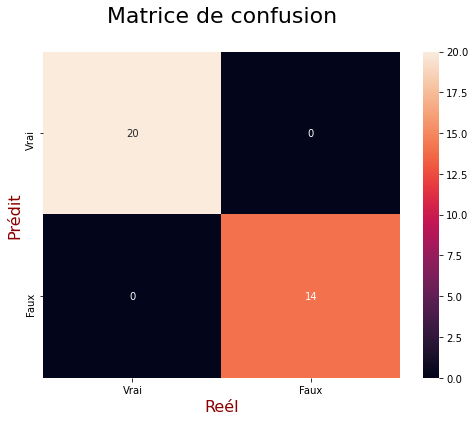

In [524]:
#Affichage avec Seaborn
fig = plt.figure(figsize=(8,6))
sn.heatmap(conf_matrix, annot=True, xticklabels=["Vrai","Faux"], yticklabels=["Vrai","Faux"])

font = {'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

plt.xlabel("Reél", fontdict=font)
plt.ylabel("Prédit", fontdict=font)
plt.title("Matrice de confusion\n", fontsize=22)

plt.savefig("P6_02_graphiques/Matrice de confusion.jpeg", format='jpg', bbox_inches='tight')
plt.show()


Les chiffres sur la diagonale indiquent les éléments bien classés à savoir les vrais positifs et vrais négatifs.
Regardons comment les probabilités sont distribués :

# Distribution des probabiltés

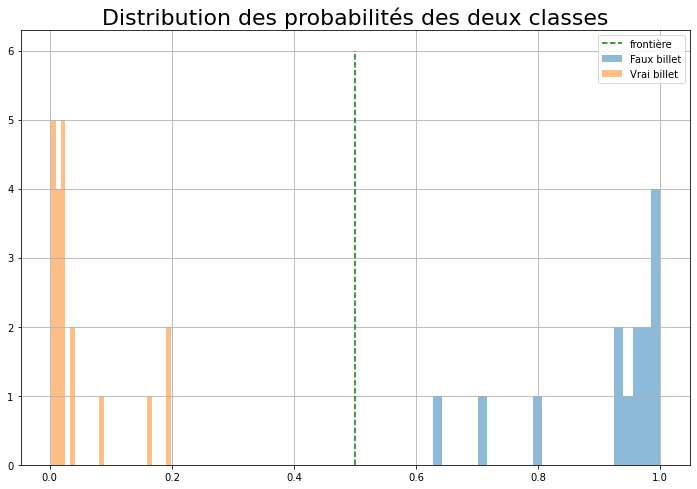

In [525]:
df_proba = pd.DataFrame(score, columns=['proba'])
df_proba['is_genuine'] = y_test.values

fig = plt.figure(figsize=(12,8))
df_proba[df_proba['is_genuine'] == 1]['proba'].hist(bins=25, label='Faux billet', alpha=0.5)
df_proba[df_proba['is_genuine'] == 0]['proba'].hist(bins=25, label='Vrai billet', alpha=0.5)
plt.plot([0.5, 0.5], [0, 6], 'g--', label="frontière")
plt.title('Distribution des probabilités des deux classes', fontsize=22)

plt.savefig("P6_02_graphiques/Distribution des probabilités des deux classes.jpeg", format='jpg', bbox_inches='tight')
plt.legend()


Plus l’aire commune aux deux distributions est petite, plus le modèle est confiant. Cette aire commune est reliée à la courbe ROC. On remarque ici qu'il n'y a aucune aire commune.

# Courbe ROC

La courbe ROC (Receiver Operating Characteristic) représente la sensibilité en fonction de la spécificité pour différents seuils de décision. L'aire sous la courbe ROC, l'AUC (Area Under the ROC ), est une mesure de la qualité de la classification qui varie entre 0.5 dans le pire des cas et 1 dans le meilleur des cas.

In [526]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr1, tpr1, seuil1 = roc_curve(y_test, probas[:, 1], pos_label=lr.classes_[1], drop_intermediate=False)
df_truepos = pd.DataFrame(dict(fpr=fpr1, tpr=tpr1, seuil=seuil1)).copy()
df_truepos.sample(10)

,fpr,tpr,seuil
14,0.00,1.000000,0.627896
24,0.50,1.000000,0.019256
25,0.55,1.000000,0.018919
18,0.20,1.000000,0.083217
34,1.00,1.000000,0.001987
32,0.90,1.000000,0.006987
5,0.00,0.357143,0.983667
0,0.00,0.000000,1.999216
13,0.00,0.928571,0.706574
28,0.70,1.000000,0.010279


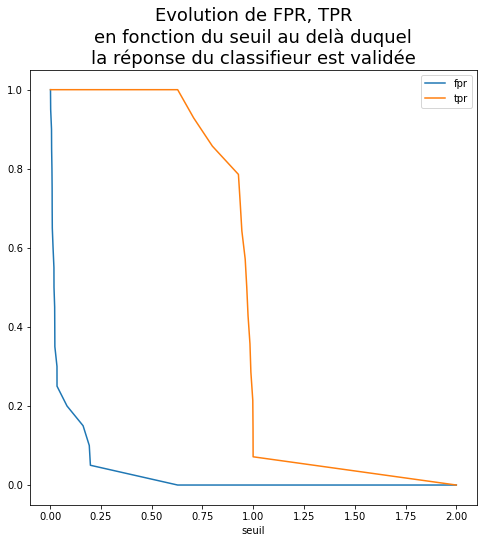

In [527]:
ax = df_truepos.plot(x="seuil", y=['fpr', 'tpr'], figsize=(8, 8))
ax.set_title("Evolution de FPR, TPR\nen fonction du seuil au delà duquel\n" +
             "la réponse du classifieur est validée", fontsize=18);
plt.savefig("P6_02_graphiques/Evolution de FPR, TPR.jpeg", format='jpg', bbox_inches='tight')
plt.show()

fpr désigne le False Positive Rate autrement dit le taux de faux positive, si la tâche est déterminer si un billet est vrai, le taux désigne la proportion de faux billets classés par le classifieur parmi les vrais billets. C’est l’erreur de classification.

tpr désigne le nombre de True Positive Rate. Si la tâche est déterminer si un billet est vrai, le taux désigne la proportion de vrais billets classés par le classifieur parmi les vrais billets.

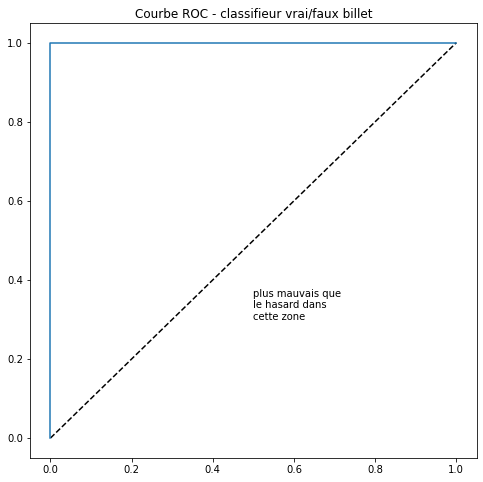

In [528]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr1, tpr1) 
ax.plot(fpr1, tpr1)
ax.set_title('Courbe ROC - classifieur vrai/faux billet')
ax.text(0.5, 0.3, "plus mauvais que\nle hasard dans\ncette zone")
plt.savefig("P6_02_graphiques/Courbe ROC - classifieur vrai-faux billet.jpeg", format='jpg', bbox_inches='tight')
plt.show()


Idée de la courbe ROC est de faire varier le «seuil» de 1 à 0 et, pour chaque cas, calculer le taux de vrai positif et de faux positif que l’on reporte dans un graphique: en abscisse le TFP, en ordonnée le TVP.

Facile à interpréter, ne nécessite pas de mise à l'échelle, ni de calcul complexe. La régression logistique fournit un score de probabilité pour les observations. Dans ce cas précis, nous sommes très proche du classifieur optimal.

La mesure AUC est l’aire sous la courbe. Elle représente la probabilité que le score d’un exemple classé faux à raison soit inférieur à un exemple classé faux à tort.

La mesure AUC ou Area Under the Curve est l’aire sous la courbe. Elle est égale à la probabilité que le score d’un exemple classé 'faux billet' à raison soit inférieur à un exemple classé 'faux billet' à tort.



In [529]:
print("La mesure AUC est ici égale à",round(aucf,2))

La mesure AUC est ici égale à 1.0


Des autres métriques sont très utilisées, la précision et le rappel. Pour chaque classifieur, on peut déterminer un seuil s au delà duquel la réponse est validée avec une bonne confiance. Parmi toutes les réponses validées, la précision est le nombre de réponses correctes rapporté au nombre de réponses validées, le rappel est le nombre de réponses correctes rapportées à toutes qui aurait dû être validées. On calcule aussi la métrique F1 qui est une moyenne harmonique entre les deux.

Précision, Recall, Score F1 Classe 0

In [530]:
from sklearn.metrics import precision_recall_curve
precision, rappel, seuil = precision_recall_curve(y_test, probas[:, 1], pos_label=lr.classes_[1])
df_prre = pd.DataFrame(dict(precision=precision, rappel=rappel,
                             seuil=[0] + list(seuil)))
df_prre['F1']= 2 * (df_prre.precision * df_prre.rappel) / (df_prre.precision + df_prre.rappel)
df_prre.head(15)

,precision,rappel,seuil,F1
0,1.0,1.000000,0.000000,1.000000
1,1.0,0.928571,0.627896,0.962963
2,1.0,0.857143,0.706574,0.923077
3,1.0,0.785714,0.798835,0.880000
4,1.0,0.714286,0.926917,0.833333
5,1.0,0.642857,0.935606,0.782609
6,1.0,0.571429,0.943799,0.727273
7,1.0,0.500000,0.960233,0.666667
8,1.0,0.428571,0.967953,0.600000
9,1.0,0.357143,0.974210,0.526316


In [531]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = lr.predict(X_test)

#Autres métriques d'évaluation du modèle
print('  - Precision: ' +str(round(precision_score(y_test, y_pred)*100, 2)), '%')
print('  - Recall: ' +str(round(recall_score(y_test, y_pred)*100, 2)), '%')
print('  - F1 score: ' +str(round(f1_score(y_test, y_pred)*100, 2)), '%')

  - Precision: 100.0 %
  - Recall: 100.0 %
  - F1 score: 100.0 %


In [532]:
#Autres métriques d'évaluation du modèle 
print('  - Accuracy:' +str(round(metrics.accuracy_score(y_test, y_pred)*100, 2)), '%')
print('  - Precision:' +str(round(metrics.precision_score(y_test, y_pred)*100, 2)), '%')
print('  - Recall:' +str(round(metrics.recall_score(y_test, y_pred)*100, 2)), '%')
print('  - F1 score:' +str(round(metrics.f1_score(y_test, y_pred)*100, 2)), '%')

  - Accuracy:100.0 %
  - Precision:100.0 %
  - Recall:100.0 %
  - F1 score:100.0 %


En conclusion, les métriques d'évaluation que nous obtenons sont très satisfaisantes. Après l'évaluation des performances du modèle de prédiction 'lr', ce modèle est retenu pour sa fiablité et sa performance.

________________________________________________________________________________________________________________________________

# Tests de l'algorithme Scikit-learn sur le fichier exemple

Régression logistique avec statsmodels

Nous allons à présent vérifier l'algorithme de prédiction sur un jeu de données inconnues.

In [533]:
#importation du fichier exemple
dataset_new = pd.read_csv("example.csv", sep=",", decimal=".", header=0)
dataset_new

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [534]:
#creation des variables et identifiants
X_new = dataset_new[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
id_new = dataset_new[["id"]]

In [535]:
#calcul des probabilités d'affectation sur l'échantillon exemple
probas_new = lr.predict_proba(X_new)
print(probas_new)

[[0.05100625 0.94899375]
 [0.01362652 0.98637348]
 [0.03424218 0.96575782]
 [0.86732434 0.13267566]
 [0.99529364 0.00470636]]


In [536]:
#score de presence : Probalilité de chance que le billet soit FAUX (is_genuine = 1)
score_new = probas_new[:,1]
print(score_new)

[0.94899375 0.98637348 0.96575782 0.13267566 0.00470636]


In [537]:
#affichage du dataframe final
dataset_new["proba_false"] = score_new
dataset_new

,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_false
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.948994
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.986373
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.965758
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.132676
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.004706


Si la probabilité de "faux" est supérieur à 0.5, alors le billet est considéré comme faux :

In [538]:
#calcul de la variable is_genuine
dataset_new["is_genuine"] = np.where(dataset_new["proba_false"]>=0.5, 'Non', 'Oui')
dataset_new

,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_false,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.948994,Non
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.986373,Non
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.965758,Non
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.132676,Oui
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.004706,Oui


In [539]:
#traitement du Dataframe pour meilleure compréhension :
dataset_new_fin = dataset_new[["id","proba_false","is_genuine"]].rename(columns={"id":"Identifiant du billet testé",
                                                                                 "proba_false":"Probabilité de faux billet (%)",
                                                                                 "is_genuine":"Est authentique ?"})
dataset_new_fin["Probabilité de faux billet (%)"] = round((dataset_new_fin["Probabilité de faux billet (%)"]*100),2)
dataset_new_fin

,Identifiant du billet testé,Probabilité de faux billet (%),Est authentique ?
0,A_1,94.90,Non
1,A_2,98.64,Non
2,A_3,96.58,Non
3,A_4,13.27,Oui
4,A_5,0.47,Oui


Nous avons donc testé un fichier exemple, contenant des données inconnues, afin de vérifier si notre algorithme de prédiction est fiable. A présent, nous allons isoler la procédure dans un nouveau Notebook afin de tester des fichiers externes. 